# Fast Furier Transform
La Transformada Rápida de Fourier (FFT) es uno de los algoritmos más importantes en el procesamiento de señales y análisis de datos. Definido y explicado por James W. Cooley y John W. Tukey en 1965 ([Paper original](http://www.ams.org/journals/mcom/1965-19-090/S0025-5718-1965-0178586-1/S0025-5718-1965-0178586-1.pdf)).

FFT es rápida porque tiene una complejidad computacional, esto es una cantidad de operaciones para realizar su objetivo, igual a $\mathcal{O}[N log N]$, mientras que la Transformada Discreta de Fourier (DFT) tiene una complejidad computacional igual a $\mathcal{O}[N^2]$. La DFT, como asi tambien la version continua de la transformada de fourier, tiene una función transformadora y otra inversa que revierte la transformación definidad asi:

#### Forward Discrete Fourier Transform (DFT):
$$X_k=\sum_{n=0}^{N-1}x_n \cdot e^{-i2\pi kn/N}$$

#### Inverse Discrete Fourier Transform (IDFT):
$$x_n={1 \over N}\sum_{k=0}^{N-1}X_ke^{-i2\pi kn/N}$$

La transformación desde $x_n \to X_k$ es un traducción desde el dominio de configuración (tiempo o espacio) al dominio de las frecuencia. 

¿Para que sirve realizar esta traducción de un fenomeno al dominio de la frecuencia?
Muchas operaciones que en el dominio del tiempo o el espacio requieren calculos complejos para ser llevados a cabo, en el dominio de la frecuencia se puede realizar tambien, pero como una sucecion de simples sumas y restas. Luego de realizadas las operaciones, se aplica la IDFT sobre los $X_k$ y se obtienen nuevamente los datos en el dominio de configuración.

Por la importanca de la FFT en muchos campos, Python contiene muchas herramientas estandar y wrappers para realizar esta operación. NumPy y SciPy contienen wrappers the algoritmos extremadamente probados de la libreria FFTPACk, que se pueden encontrar en los submodulos **numpy.fft** y **scipy.fftpack** respectivamente. Tambien se puede acceser al paquete [Fast Fourier Transform in the West (FFTW)](http://www.fftw.org/), que es la mejor implementacion de FFT hasta la fecha, a partir del wrapper para Python [PyFFTW](https://pypi.python.org/pypi/pyFFTW).

## Implementando DFT
Por simplicidad, vamos a concentrarnos en la implementación de la **Forward DFT**, ya que la **IDFT** se puede calcular de manera similar. Viendo la expreción de DFT definida anteriormente, vemos que es nada mas, y nada menos, que una operacion linieal: una multiplicación de matriz-vector de $\overrightarrow{x}$

$$\overrightarrow{X}=M  \cdot \overrightarrow{x}$$

con la matriz M igual a

$$M_{kn}=e^{-i2\pi kn\;/\;N}$$

Con esto en mente, podemos computar la DFT usando multiplicación simple de matrices de la siguiente forma:

In [35]:
import numpy as np
def DFT(x):
    """Computo discrete Fourier Transform de un 1D array x"""
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))
    M = np.exp(-2j * np.pi * k * n / N)
    return np.dot(M, x)

Podemos validar el correcto funcionamiento de nuestro algoritmo con la implementacion de Numpy:

In [36]:
x = np.random.random(1024)
np.allclose(DFT(x), np.fft.fft(x))

True

Sólo para confirmar la lentitud de nuestro algoritmo, podemos comparar los tiempos de ejecución de estos dos enfoques:

In [37]:
%timeit DFT(x)
%timeit np.fft.fft(x)

124 ms ± 1.58 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
23 µs ± 904 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Nuestra implementación es al rededor de 1000 veces mas lento que la implementación de Numpy. Pero eso no es lo peor. Para un vector de longitud $N$, FFT escala siguiendo $\mathcal{O}[N log N]$, mientras que nuestro 'lento' algoritmo escala, como vimos anteriormente, siguiendo $\mathcal{O}[N^2]$. Esto quiere decir que para $N=10^6$ elementos, podemos esperar que FFT complete la operacion en alrededor de 50 ms, mientras nuestro algoritmo va a tardar cerca de 20 horas! 

Por este tipo de cosas, es importante realizar optimizaciones en el código.

## Simetrias en DFT
Una de las herramientas mas importantes que se debe explotar cuando se contruyen algoritmos, es las posibles simetrias que poseen los problemas a resolver. Si se puede demostrar analiticamente que un problema esta relacionado simetricamente con otro, se puede computar un sub-resultado una vez y ahorrar ese costo computacional extra que implicaria calcula el sub-resultado simetrico. Cooley y Tukey usaron exactamante esa aproximación  para derivar la FFT.

Comenzamos preguntandonos cual es el valor de $X_{N+k}$ a partir de la siguiente expresion:

$X_{N+k}=\sum_{n=0}^{N-1}x_n \cdot e^{-i2\pi(N+k)n\;/\;N}$

$\;\;\;\;\;\;\;=\sum_{n=0}^{N-1}x_n \cdot e^{-i2\pi n} \cdot e^{-i2\pi kn\;/\;N}$

$\;\;\;\;\;\;\;=\sum_{n=0}^{N-1}x_n \cdot e^{-i2\pi kn}$

Si hacemos $e^{2\pi in}=1$, lo cual se mantiene para cualquier $n$ tenemos que:

$X_{N+k}=X_k$ 

para cualquier entero i. Esta simetria nos va permitir computar la DFT mucho mas rapido.

## Desde DFT a FFT: Explotando Simetrias
Cooley y Tukey mostraron que es posible dividir el cálculo de DFT en dos partes más pequeñas. A partir de la definición de la DFT tenemos:

$X_k = \sum_{n=0}^{N-1}x_n \cdot e^{-i2\pi kn\;/\;N}$

$X_k = \sum_{m=0}^{N/2-1}x_{2m} \cdot e^{-i2\pi k(2m)\;/\;N}+\sum_{m=0}^{N/2-1}x_{2m+1} \cdot e^{-i2\pi k(2m+1)\;/\;N}$

$X_k = \sum_{m=0}^{N/2-1}x_{2m} \cdot e^{-i2\pi km\;/\;(N/2)}+e^{-i2\pi k\;/\;N}\sum_{m=0}^{N/2-1}x_{2m+1} \cdot e^{-i2\pi km)\;/\;(N/2)}$

Hemos dividido la única transformada discreta de Fourier en dos términos que se ven muy similares a las transformadas de Fourier discretas más pequeñas, una para los valores impares y otra para los valores pares. Hasta ahora, sin embargo, no hemos eliminado ningún ciclo computacional. Cada término consiste en $(N/2)N$ operaciones, para un total de $N^2$.

El truco consiste en usar las simetrias en cada uno de esos terminos. Como el rango de $k$ es $0\leq k < N$, mientras el rango de $n$ es $0\leq n < M \equiv N/2$, pudimos ver previamente, que gracias a las propiedades simetricas, podemos realizar solo la mitad de los calculos para cada sub-problema. Entonces, nuestro problema con complejidad computacional $\mathcal{O}[N^2]$ se vuelve $\mathcal{O}[M^2]$, donde $M$ tiene la mitad del tamaño de $N$.

Pero no hay razón para detenernos allí: mientras nuestras transformadas de Fourier más pequeñas tengan un valor de M, podemos aplicar de nuevo este enfoque de "divide y venceras", reduciendo a la mitad el coste computacional cada vez, hasta que nuestras matrices sean lo suficientemente pequeñas como para que la estrategia ya no sea beneficiosa. En este límite asintótico, este enfoque recursivo escala como $\mathcal{O}[N\;\log\;N]$.

## Ejercicio 1

1- Implementar algoritmo Fast Fourier Transform (FFT) y comparar con el algoritmo implementado previamente, como asi tambien, con la implementacion de NumPy o SciPy.

## Ejemplo aplicación de FFT
Si tomamos como función generadora de una señal la siguiente función:

$$s=\cos(2\pi t)$$

Y utilizando las funciónes ya implementadas en SciPy:

**Funciones utilizadas:**

* Frecuencia de muestreo: [fftfreq](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.fftfreq.html)
* Forward FFT: [rfft](https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.rfft.html)
* Inverse FFT: [irfft](https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.irfft.html#numpy.fft.irfft)

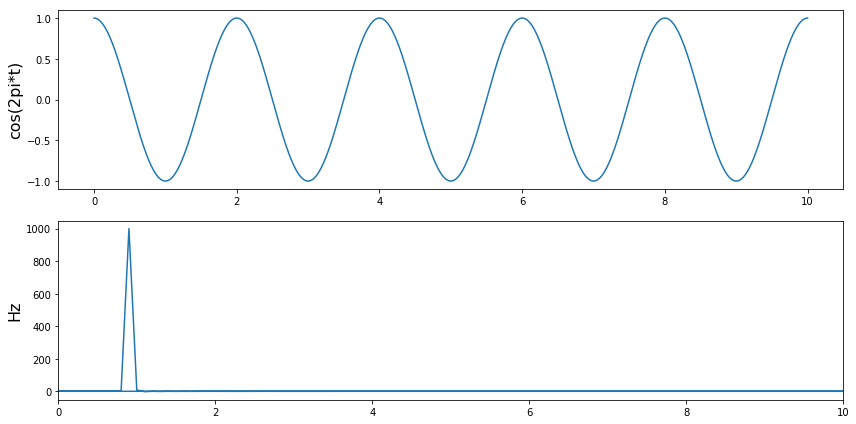

In [38]:
import numpy as np
from scipy.fftpack import rfft, irfft, fftfreq
%matplotlib inline
import matplotlib.pyplot as plt

time   = np.linspace(0,10,2000)
signal =  np.cos(np.pi*time)

W = fftfreq(signal.size, d=time[1]-time[0]) #Frecuencia de muestreo
f_signal = rfft(signal)

# plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

ax1.plot(time,signal)
ax1.set_ylabel('cos(2pi*t)',fontsize=16)

ax2.plot(W,f_signal)
ax2.set_xlim([0, 10])
ax2.set_ylabel('Hz',fontsize=16)
fig.tight_layout()
plt.show()

Claramente, la función utilizada tiene una frecuencia de 1 hertz, como puede verse en el grafico en el dominio de la frecuencia obtenido a partir de fourier.

#### Ejemplo Practico
Ahora supongamos que tenemos una señal a la cual queremos aplicarle un filtro. 

$s(t)=a\cos(bt)+c\cos(dt)$

donde: 

$a=2$

$b=5\pi$

$c=1$

$d=7\pi$

Si queremos filtrar todo el espectro de la señal que esta por debajo de los 6 Hz, entonces:

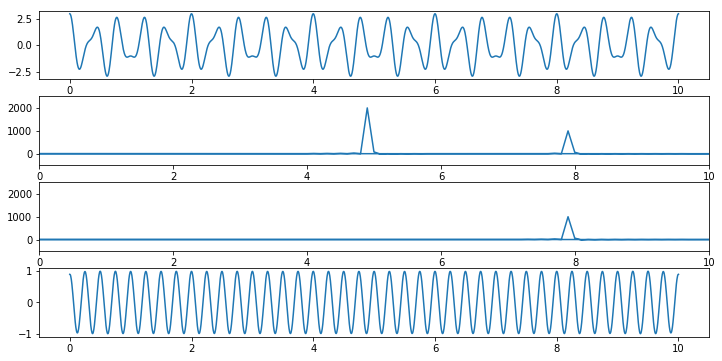

In [39]:
import numpy as np
from scipy.fftpack import rfft, irfft, fftfreq
%matplotlib inline
from matplotlib import pyplot as plt

# Teniendo una señal en el dominio del tiempo
time   = np.linspace(0,10,2000)
signal = 2 * np.cos(5*np.pi*time) + np.cos(8*np.pi*time)

# Aplico FFT 
W = fftfreq(signal.size, d=time[1]-time[0])
f_signal = rfft(signal)

# Suponiendo que nuestra señal original esta en segundos, al transformala 
# nuestras frecuencias estaran en Hertz (Hz)
cut_f_signal = f_signal.copy()
# remuevo del vector todas las señales inferiores a 6 Hz
cut_f_signal[(W<6)] = 0

# IFFT para obtener la nueva señal en el dominio del tiempo
cut_signal = irfft(cut_f_signal)

# plots
fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(hspace=0.25)

ax1 = fig.add_subplot(411)
ax1.plot(time,signal)

ax2 = fig.add_subplot(412)
ax2.plot(W,f_signal)
ax2.set_xlim([0, 10])
ax2.set_ylim([-500, 2500])

ax3 = fig.add_subplot(413)
ax3.plot(W,cut_f_signal)
ax3.set_xlim([0, 10])
ax3.set_ylim([-500, 2500])

ax4 = fig.add_subplot(414)
ax4.plot(time,cut_signal)

plt.show()

## Ejercicio 2
Crear un filtro en el dominio de la frecuencia que reduzca el ruido de la siguiente señal: 

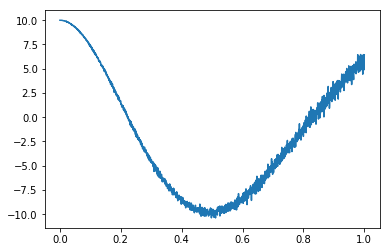

In [40]:
import numpy as np
from scipy.fftpack import rfft, irfft, fftfreq
%matplotlib inline
from matplotlib import pyplot as plt

def testfunc(x):
    return 10 * np.cos(7.8 * np.log(1 + x)) / (1 + 0.1 * x**2)
    
Dn = 2000

# Teniendo una señal en el dominio del tiempo
time   = np.linspace(0,1,Dn)
data   = testfunc(time) + 0.1 * np.random.normal(0, 5, Dn) * time

plt.plot(time,data)
plt.show()

# Transformada de furier con imagenes
Primero veremos cómo encontrar la transformada de Fourier usando Numpy. Numpy tiene la función np.fft.fft2() que nos proporciona la transformación de frecuencia que será una matriz compleja. Su primer argumento es la imagen de entrada, que es en escala de grises. El segundo argumento es opcional, que decide el tamaño de la matriz de salida. Si es mayor que el tamaño de la imagen de entrada, la imagen de entrada se rellena con ceros antes del cálculo de FFT. Si es menor que la imagen de entrada, la imagen de entrada se recortará. Si no se pasan los argumentos, el tamaño de la matriz de salida será el mismo que la entrada.

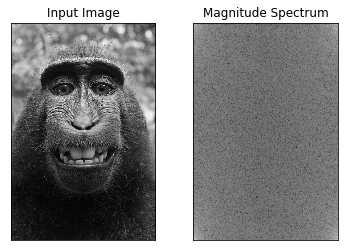

In [41]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('img/selfie.jpg',0)
f = np.fft.fft2(img)
magnitude_spectrum = 20*np.log(np.abs(f))

plt.subplot(121)
plt.imshow(img, cmap = 'gray')
plt.title('Input Image')
plt.xticks([]), plt.yticks([])

plt.subplot(122)
plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum')
plt.xticks([]), plt.yticks([])
plt.show()

Ahora, una vez que obtenga el resultado, el componente de frecuencia cero estará en la esquina superior izquierda. Si desea llevarlo al centro, debe cambiar el resultado por dividiendo $frac{N}{2}$ en ambas direcciones. Esto simplemente lo hace la función, np.fft.fftshift(). Esto simplemente se hace porque es mas facil de analizar. Una vez que encuentre la transformación de frecuencia, puede encontrar el espectro de magnitud.

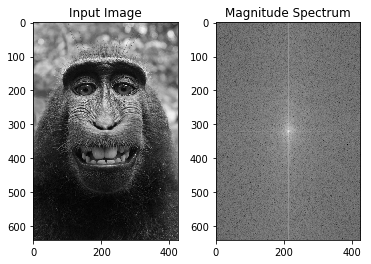

In [42]:
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image')
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum')
plt.show()

Ahora se pueden hacer algunas operaciones en el dominio de la frecuencia, como el filtrado pasa altos y reconstruir la imagen, es decir, encontrar DFT inverso. Para eso, simplemente se eliminna las bajas frecuencias con una ventana rectangular de tamaño 200x200. A continuación, aplique el desplazamiento inverso utilizando np.fft.ifftshift() para que el componente de frecuencia cero vuelva a aparecer en la esquina superior izquierda. Luego encuentra FFT inversa usando la función np.ifft2(). El resultado, de nuevo, será un número complejo. Puedes tomar su valor absoluto.

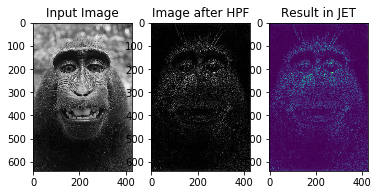

In [43]:
rows, cols = img.shape
win_half_size = 100 
crow,ccol = rows/2 , cols/2
fshift[int(crow-win_half_size):int(crow+win_half_size), int(ccol-win_half_size):int(ccol+win_half_size)] = 0
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)

plt.subplot(131)
plt.imshow(img, cmap = 'gray')
plt.title('Input Image')

plt.subplot(132)
plt.imshow(img_back, cmap = 'gray')
plt.title('Image after HPF')

plt.subplot(133)
plt.imshow(img_back)
plt.title('Result in JET')

plt.show()

## Ejercicio 3
Elegir una imagen y aplicar un filtro pasa bajos (en vez de uno pasa altos).